**Problema 6**

Modelagem de perda de clientes em Marketing (churn): Utilizar a base
disponível para desenvolver um algoritmo de classificação de clientes nas categorias
churn (deixou de ser cliente após dois anos) e não churn (não deixou de ser cliente após
dois anos) para ser utilizado por uma empresa do segmento B2B. (base de dados 6)

**Questões**

1) Descobrir quais variáveis são mais informativas na predição do churn (PCA, Fisher)

2) Verificar a influência do segmento da empresa no tempo que ela fica como cliente

3) Verificar a influência do valor mensal gasto com o churn

**Análise descritiva**

Utilizar a análise para responder as questões e mostrar a normalidade para aplicar os métodos.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install xlrd

    100% |████████████████████████████████| 112kB 3.0MB/s 


In [0]:
# plot settings 
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [0]:
df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Análise Multivariada/Relatório final/base6.xls', sheet_name=1)

In [0]:
# removendo a variável 'Duracao' da análise e do modelo pois não faz sentido usarmos ela, visto que ela é a definição do churn
duracao = df['Duracao']

target = df['censura']
data = df.drop(['Cliente', 'censura', 'Duracao'], axis=1)
cols = data.columns

In [0]:
'''
Cliente 			ID cliente
Duracao				tempo de permanencia do cliente (em dias)
censura				1 se cliente não abandonou a empresa em um período de dois anos, 0 cc
valorGasto		Valor médio mensal gasto com campanhas de marketing para reter cliente
indB2B				1 se cliente é do segmento B2B
receita				Receita anual da empresa (em milhões)
nEmpregados		número de empregados
TotalProdutos	Número de tipos de produtos que a empresa comprou enquanto cliente
TotalFreq			número total de compras da empresa
''';

# Análise descritiva 

## Analisando a dispersão por classe

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


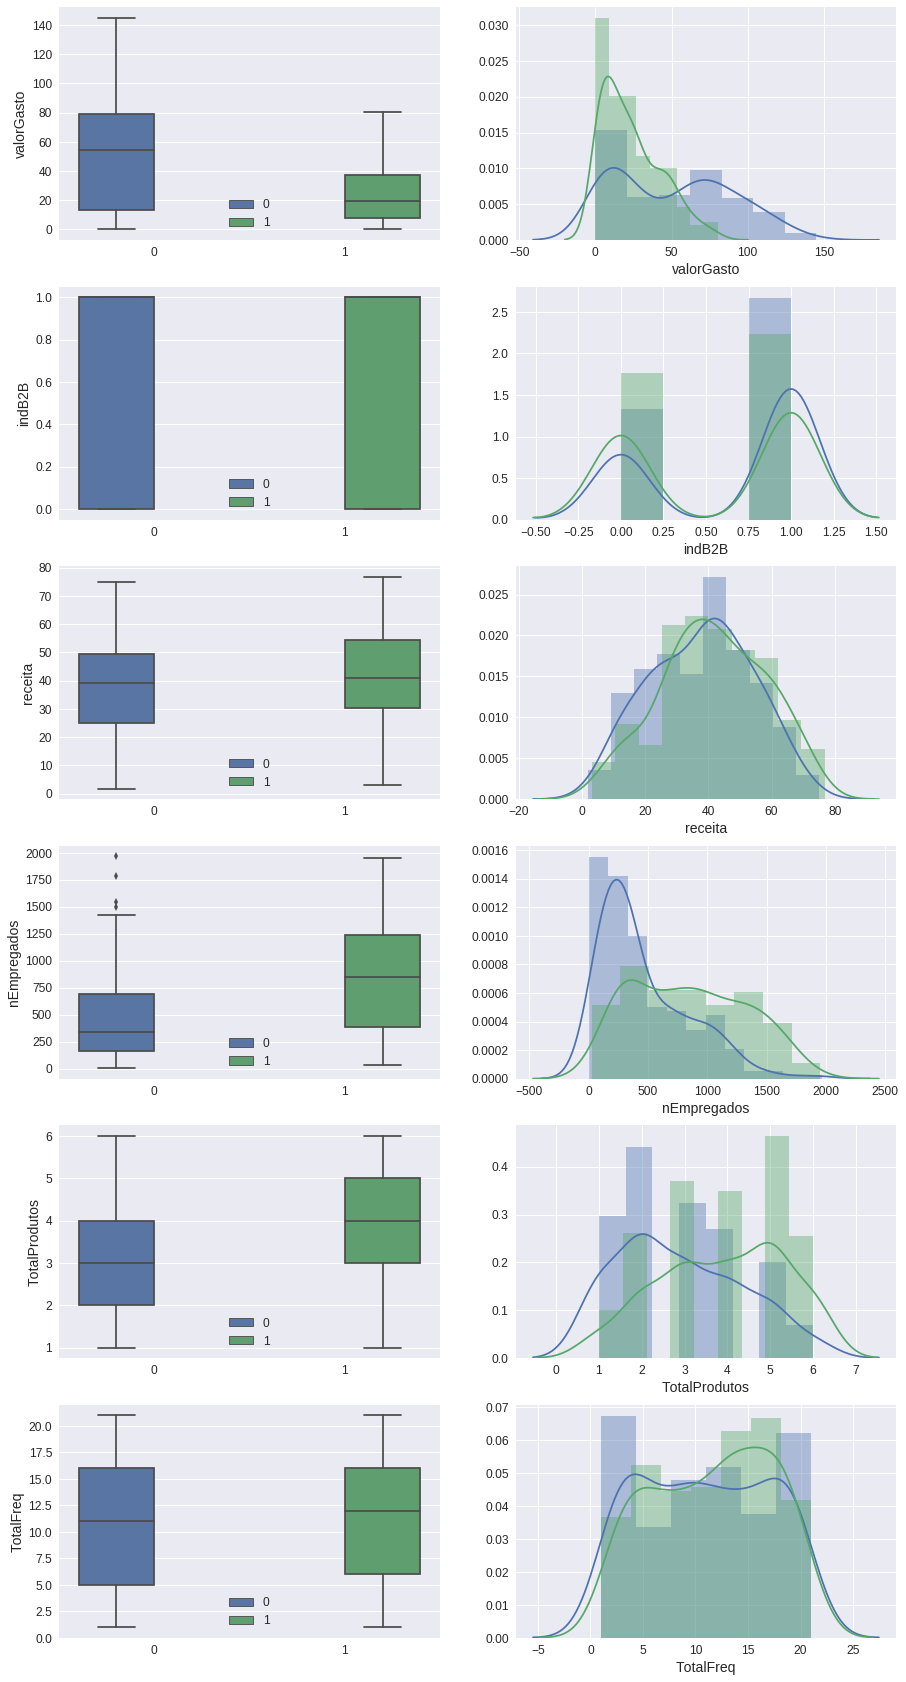

In [0]:
# box plot e histograma das variáveis por classe (censura)
n = len(cols)

plt.figure(figsize=(15, 30))

for i, col in enumerate(cols):
    plt.subplot(n, 2, (2*i)+1)    
    sns.boxplot(x=target, y=data[col], hue=target).set(xlabel='')
    plt.legend(loc="lower center")
    
    plt.subplot(n, 2, (2*i)+2)
    for i in range(2):
      sns.distplot(data.loc[target==i, col])
      
      
plt.show()

Olhando a distribuição das variáveis, vemos que a metade delas não possuem uma distinção clara em suas distribuições quando separadas por **censura** (churn), entretanto notamos 3 variáveis que destacam uma diferença considerável na ditribuição: **valorGasto**, **nEmpregados** e **TotalProdutos**.

* É interessante notar que o valor médio mensal gasto para manter a empresa como cliente (**valorGasto**) é menor na maioria das empresas que ficaram 2 anos, o resultado faz sentido quando pensamos que o investimento em marketing vai caindo conforme o cliente fica mais tempo com a empresa, logo os clientes que estão a mais tempo tendem a ter um investimento médio mensal menor. Podemos comprovar essa hipótese observando uma correlação negativa alta entre **valorGasto** e **Duracao** no gráfico da matriz de correlação abaixo. 

* A variável **nEmpregados** nos mostra que há uma tendência maior de empresas com numéro de empregados menor (aprox < 750) sairem antes de 2 anos.

* Através da variável **TotalProdutos** notamos que em média as empresas que sairam antes de 2 anos compraram menos produtos.

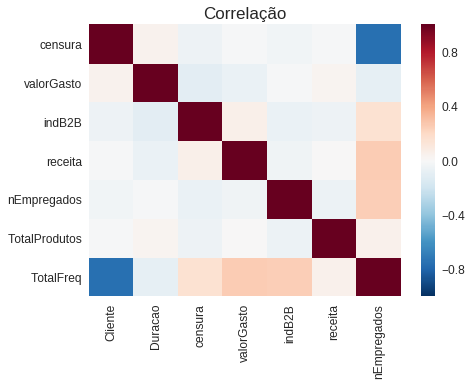

In [0]:
# heatmap da matriz de correlação

plt.figure(figsize=(7, 5))

temp = pd.concat([data, duracao], axis=1)

sns.heatmap(temp.corr(), 
            xticklabels=df.columns.values,
            yticklabels=df.columns.values)
plt.xticks(rotation='vertical')
plt.title('Correlação')

plt.show()

## Discriminante linear de Fisher

In [0]:
# discriminante de fisher

#separando grupos (censura 0 e censura 1)
c0 = data[target==0]
c1 = data[target==1]

#obtendo a pontuação para cada variável
fisher_score = ( (c0.mean() - c1.mean()).pow(2) / ( c0.var() + c1.var() ) ).values

#ordenando
fisher_score, cols_f =  zip(*sorted(zip(fisher_score, cols), reverse=True))

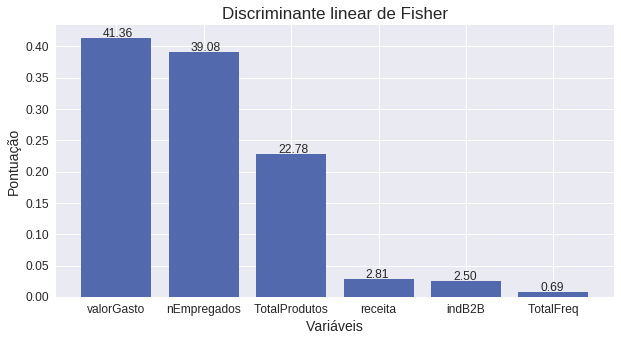

In [0]:
# plotando a pontuação obtida por cada variável

plt.figure(figsize=(10, 5))
plt.bar(x=range(len(cols)), height=fisher_score, color='#5369ad')
plt.title("Discriminante linear de Fisher")
plt.ylabel("Pontuação")
plt.xlabel("Variáveis")
plt.xticks(range(len(cols)), cols_f)
for i, v in enumerate(fisher_score):
  plt.text(i - .15, v + 0.002, '%.2f'%(v*100))
  
plt.show()

A pontuação de Fisher confirma a análise feita através dos boxplots e histogramas, ou seja, as variáveis com maior poder preditivo são **valorGasto**, **nEmpregados** e **TotalProdutos**.

In [0]:
cols_pred = ['valorGasto', 'nEmpregados', 'TotalProdutos']

## Análise de Componentes Principais

In [0]:
from sklearn.decomposition import PCA

# normalizando (z-score)
data_z = ( data - data.mean() ) / data.std()

# obtendo os componentes
pca = PCA()
pca.fit( data_z );

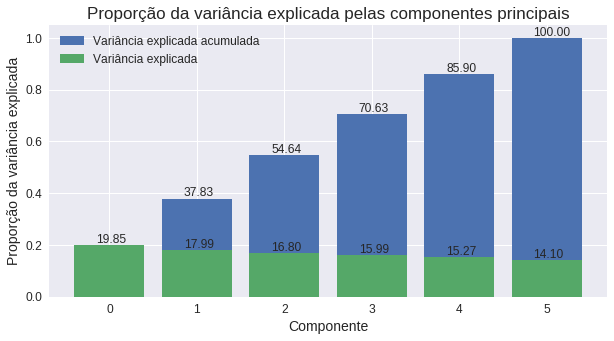

In [0]:
# plotando a variância explicada pelas componentes principais
plt.figure(figsize=(10, 5))

x = range(len(pca.components_))
y = np.cumsum(pca.explained_variance_ratio_)
cum_var = plt.bar(x=x, height=y)
for i, v in enumerate(y):
      plt.text(i - .15, v + .01, '%.2f'%(v*100))


y = pca.explained_variance_ratio_
var = plt.bar(x=x, height=y)
for i, v in enumerate(y):    
  if i > 0:
      plt.text(i - .15, v + .01, '%.2f'%(v*100))

plt.title('Proporção da variância explicada pelas componentes principais')
plt.xlabel('Componente')
plt.ylabel('Proporção da variância explicada')
plt.legend((cum_var[0], var[0]), ('Variância explicada acumulada', 'Variância explicada'))

plt.show()

Devido a baixa correlação entre as variáveis era de se esperar que a análise de componentes principais não iria resultar em uma redução de dimensionalidade considerável, a variância explicada ficou muito bem distribuida entre os componentes (cerca de 20% para cada), dessa forma não faz sentido analisarmos a interpretação das componentes buscando interpretações para nossas componentes principais. 

# Classificação

## Escolha do K

In [0]:
# treina e testa o KNN com cross validation (10 folds) variando o k de 1 a 100 
# retorno: uma tupla contendo o erro médio quadrático em treino e teste para cada uma das 100 execuções (sendo 10 execuções para cada uma das 100)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(10, shuffle=True)
k_range = range(1, 101)
err_test = np.zeros( (len(k_range), 10) )
err_train = np.zeros( (len(k_range), 10) )

for k in k_range:
    clf = KNeighborsClassifier(k)

    for i, (train_index, test_index) in enumerate(kf.split(data)):
        # separa conjunto de treino e de teste
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # treinando o modelo
        clf = clf.fit(x_train, y_train)

        # predizendo em teste (classificando)
        y_pred = clf.predict(x_test)
        err_test[k-1][i] = ( mean_squared_error(y_test, y_pred) )

        # predizendo em treino
        y_pred = clf.predict(x_train)
        err_train[k-1][i] = ( mean_squared_error(y_train, y_pred) )

In [0]:
# executa o KNN com validação cruzada para k entre 1 e 100, retorna o erro em treino e teste
err_train_test_6 = err_k(data)
err_train_test_3 = err_k(data[cols_pred])

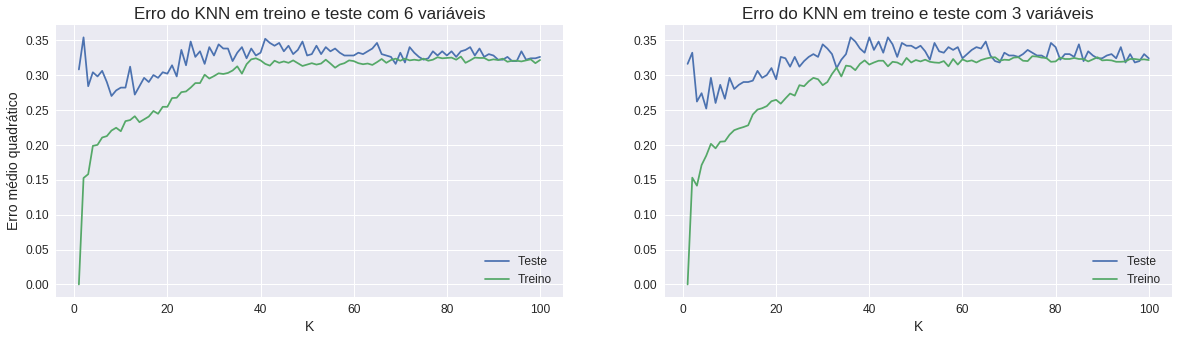

In [0]:
# plot do erro em teste e treino
plt.figure( figsize=(20, 5) )

# faz o plot para 6 e 3 variáveis
for i in range(2):

  plt.subplot(1, 2, i+1)
  x = range(1, err_train_test_6[1].shape[0]+1)

  if i==0:
    y_train     = err_train_test_6[0].mean(axis=1)
    y_test      = err_train_test_6[1].mean(axis=1)
  else:
    y_train     = err_train_test_3[0].mean(axis=1)
    y_test      = err_train_test_3[1].mean(axis=1)
    
  plt.plot(x, y_test, label="Teste")
  plt.plot(x, y_train, label="Treino")
  
  plt.title("Erro do KNN em treino e teste com %d variáveis" % (6-3*i))
  plt.xlabel("K")
  if i == 0:
    plt.ylabel("Erro médio quadrático")
  plt.legend(loc="lower right")
  
plt.show()

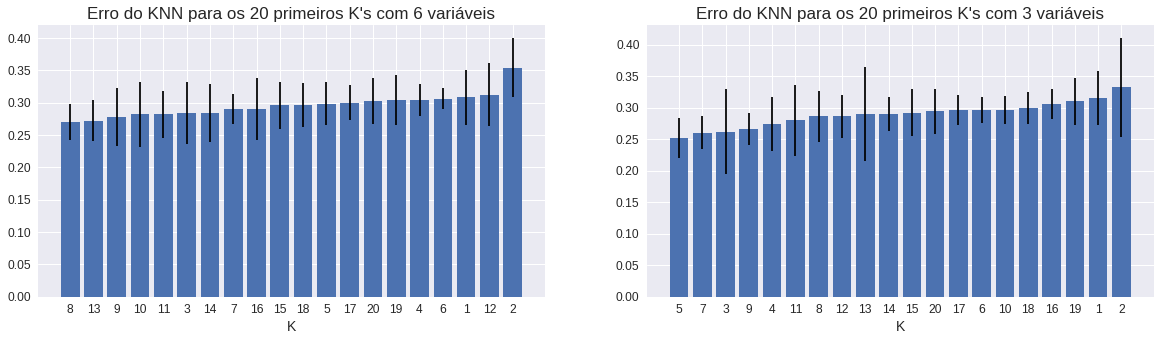

In [0]:
# plotando desempenho para os diferentes k's até 20
plt.figure( figsize=(20, 5) )

max_k = 20 +1
k_range = range(1, max_k)
k_value = [0, 0]

# faz o plot para 6 e 3 variáveis
for i in range(2):
  plt.subplot(1, 2, i+1)
  
  if i==0:
    y     = err_train_test_6[1][:max_k].mean(axis=1)
    y_err = err_train_test_6[1][:max_k].std(axis=1)
  else:
    y     = err_train_test_3[1][:max_k].mean(axis=1)
    y_err = err_train_test_3[1][:max_k].std(axis=1)

  #ordenando
  y, x, y_err =  zip(*sorted(zip(y, k_range, y_err)))
  
  k_value[i] = x[0]
  
  plt.bar(x=k_range, height=y, yerr=y_err)
  plt.title("Erro do KNN para os %d primeiros K's com %d variáveis" % ((max_k-1), (6-3*i)))
  plt.xlabel("K")
  if x==0:
    plt.ylabel("Erro médio quadrático")
  plt.xticks(k_range, x)

plt.show()

## Classificadores

In [0]:
# função que treina e classifica um conjunto de dados 'data' nos 4 classificadores analisados no trabalho usando cross-validation (5 fold)
# retorna uma tripla sendo o primeiro elemente um dicionário contendo a acurácia dos classificadores, 
#     o segundo um dicionário contendo como valor a tripla (y_true, prob y==1, y predito)
#     e o terceiro é uma lista do nome dos classificadores

def classificadores(data, k_value):
  # classificadores
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
  from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
  # medidas
  from sklearn.metrics import accuracy_score
  # seleção
  from sklearn.model_selection import KFold

  # instancia os classificadores
  dt = DecisionTreeClassifier()
  knn = KNeighborsClassifier(k_value)
  lda = LDA()
  qda = QDA()

  clfs = (dt, knn, lda, qda)
  clfs_names = ("Árvore de decisão", "KNN", "LDA", "QDA")

  kf = KFold(5, shuffle=True)

  score =       {name : np.zeros(5) for name in clfs_names}
  y_test_pred = {name : () for name in clfs_names}
  
  for i, (clf, clf_name) in enumerate( zip(clfs, clfs_names) ):
    for j, (train_index, test_index) in enumerate( kf.split(data) ):
      # separa conjunto de treino e de teste
      x_train, x_test = data.iloc[train_index], data.iloc[test_index]
      y_train, y_test = target.iloc[train_index], target.iloc[test_index]

      # treinando o modelo
      clf = clf.fit(x_train, y_train)

      # predizendo valores (classificando)
      y_pred = clf.predict(x_test)
      y_pred_proba = clf.predict_proba(x_test)[:, 1]
      
      # armazena a acurácia do classificador clf_name na iteração j do cross-validation
      score[clf_name][j] = ( accuracy_score(y_test, y_pred) )
      
      # armazena uma tupla com o y teste, y proba e y predito do classificador clf_name
      y_test_pred[clf_name] = (y_test, y_pred_proba, y_pred)
      
  # retorna basicamente a acurácia, os y's e o nome dos classificadores
  return (score, y_test_pred, clfs_names)

In [0]:
# obtendo o desempenho dos classificadores com 6 e 3 variáveis
score_6, y_test_pred_6, clfs_names = classificadores(data, k_value[0])
score_3, y_test_pred_3, _          = classificadores(data[cols_pred], k_value[1])

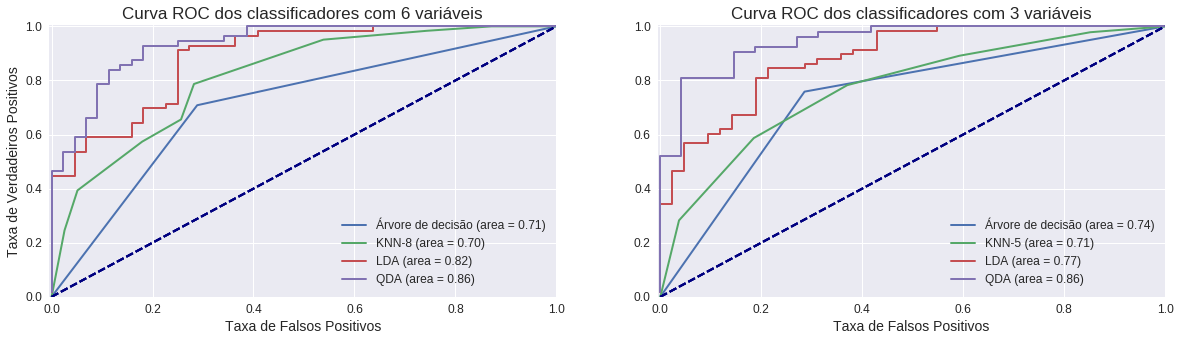

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
  
# plot da curva ROC
plt.figure(figsize=(20, 5))

# faz o plot para 6 e 3 variáveis
for i in range(2):
  plt.subplot(1, 2, i+1)
  
  # uma curva para cada classificador
  for clf in clfs_names:
    
    # calcula curva ROC e AUC
    if i==0:
      fpr, tpr, thresholds = roc_curve(y_test_pred_6[clf][0], y_test_pred_6[clf][1])
      roc_auc = roc_auc_score(y_test_pred_6[clf][0], y_test_pred_6[clf][2])
    else:
      fpr, tpr, thresholds = roc_curve(y_test_pred_3[clf][0], y_test_pred_3[clf][1])
      roc_auc = roc_auc_score(y_test_pred_3[clf][0], y_test_pred_3[clf][2])
      
    # adiciona o valor do K para plotar com essa informação no nome do classificador
    if clf == 'KNN':
      clf = clf+'-%d' % k_value[i]
    
    # plota curva ROC
    plt.plot(fpr, tpr, lw=2, label=clf + ' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('Taxa de Falsos Positivos')
    if i==0:
      plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title("Curva ROC dos classificadores com %d variáveis" % (6-3*i))
    plt.legend(loc="lower right")

plt.show()

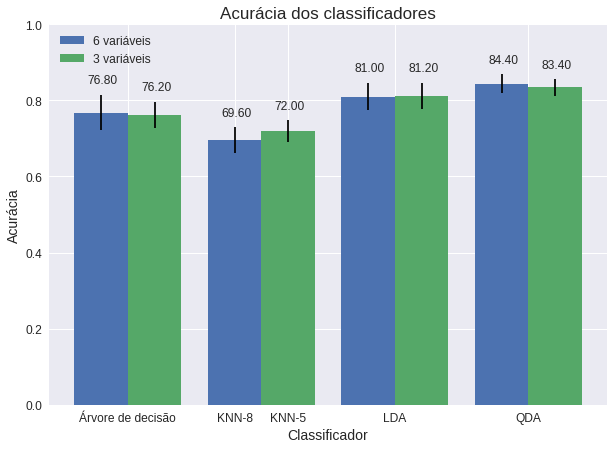

In [0]:
# plot da acuracia
plt.figure(figsize=(10, 7))

names_plot = []
for name in clfs_names:
  if name != 'KNN':
    names_plot.append(name)
  else:
    names_plot.append('KNN-%d' % k_value[0])
    names_plot.append('KNN-%d' % k_value[1])

x = np.arange(len(clfs_names))
y1 = [ score_6[clf].mean() for clf in clfs_names ]
y2 = [ score_3[clf].mean() for clf in clfs_names ]
y1_err = [ score_6[clf].std() for clf in clfs_names ]
y2_err = [ score_3[clf].std() for clf in clfs_names ]

plt.bar(x, y1, yerr=y1_err, width=0.4, label='6 variáveis')
plt.bar(x+0.4, y2, yerr=y2_err, width=0.4, label='3 variáveis')

for i, (v1, v2) in enumerate(zip(y1, y2)):    
  plt.text(i-0.1, v1+y1_err[i]+0.03, '%.2f'%(v1*100))
  plt.text(i+0.3, v2+y2_err[i]+0.03, '%.2f'%(v2*100))
      
plt.title("Acurácia dos classificadores")
plt.xlabel("Classificador")
plt.ylabel("Acurácia")
plt.xticks([0.2, 1, 1.4, 2.2, 3.2], names_plot)
plt.legend(loc="upper left")
plt.ylim(0, 1)

plt.show()